# Carregar Features

In [2]:
import pandas as pd
import numpy as np
import boto3
import sagemaker
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup

In [3]:
boto_session = boto3.Session(region_name='us-east-1')
sagemaker_client = boto_session.client(service_name='sagemaker', region_name='us-east-1')
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name='us-east-1')

In [4]:
feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

In [5]:
feature_group_name = "titanic-features"
titanic_feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=feature_store_session)

In [6]:
titanic_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:061803124211:feature-group/titanic-features',
 'FeatureGroupName': 'titanic-features',
 'RecordIdentifierFeatureName': 'PassengerId',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'PassengerId',
   'FeatureType': 'Integral'},
  {'FeatureName': 'Survived', 'FeatureType': 'Integral'},
  {'FeatureName': 'Pclass', 'FeatureType': 'Integral'},
  {'FeatureName': 'Sex', 'FeatureType': 'Integral'},
  {'FeatureName': 'Age', 'FeatureType': 'Fractional'},
  {'FeatureName': 'SibSp', 'FeatureType': 'Integral'},
  {'FeatureName': 'Parch', 'FeatureType': 'Integral'},
  {'FeatureName': 'EventTime', 'FeatureType': 'Fractional'}],
 'CreationTime': datetime.datetime(2022, 10, 24, 12, 9, 36, 247000, tzinfo=tzlocal()),
 'OfflineStoreConfig': {'S3StorageConfig': {'S3Uri': 's3://mlopsstack-mlbucket12760f44-590xj4q47o7h/features',
   'ResolvedOutputS3Uri': 's3://mlopsstack-mlbucket12760f44-590xj4q47o7h/features/061803124211/sagema

In [7]:
titanic_query = titanic_feature_group.athena_query()
titanic_table = titanic_query.table_name
output_bucket = 'martinig-athena-results-test'

In [8]:
query_string = f'SELECT * FROM "sagemaker_featurestore"."{titanic_table}";'

In [9]:
df = pd.DataFrame()
titanic_query.run(query_string=query_string, output_location='s3://'+output_bucket+'/query_results/')
titanic_query.wait()
df = titanic_query.as_dataframe()

In [10]:
df.head()

,passengerid,survived,pclass,sex,age,sibsp,parch,eventtime,write_time,api_invocation_time,is_deleted
0,14,0,3,0,39.0,1,5,1.666613e+09,2022-10-24 12:15:45.165,2022-10-24 12:10:00.000,False
1,313,0,2,1,26.0,1,1,1.666613e+09,2022-10-24 12:15:45.165,2022-10-24 12:10:00.000,False
2,347,1,2,1,40.0,0,0,1.666613e+09,2022-10-24 12:15:45.165,2022-10-24 12:10:00.000,False
3,354,0,3,0,25.0,1,0,1.666613e+09,2022-10-24 12:15:45.165,2022-10-24 12:10:00.000,False
4,355,0,3,0,-1.0,0,0,1.666613e+09,2022-10-24 12:15:45.165,2022-10-24 12:10:00.000,False


# Explorar

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-ticks')

In [13]:
df.describe()

,passengerid,survived,pclass,sex,age,sibsp,parch,eventtime
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02
mean,446.000000,0.383838,2.308642,0.352413,23.600640,0.523008,0.381594,1.666613e+09
std,257.353842,0.486592,0.836071,0.477990,17.867496,1.102743,0.806057,0.000000e+00
min,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.666613e+09
25%,223.500000,0.000000,2.000000,0.000000,6.000000,0.000000,0.000000,1.666613e+09
50%,446.000000,0.000000,3.000000,0.000000,24.000000,0.000000,0.000000,1.666613e+09
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,1.666613e+09
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,1.666613e+09


In [14]:
def plot(table, legloc='upper right',
                                    plt_style = 'seaborn-ticks',
                                    color_palette="dark",sorter=None, stacked=False,
                                    kind = 'bar', percentage = True,
                               custom_title=None, minimal=True, figsize=(19,10), width=0.7 ):     
    grouped = table
    
    #Tranform to percentages
    if percentage == True:
        grouped = np.round(grouped.divide(grouped['Total'],axis=0)*100,0)
    try:   
        del grouped['Total']
    except:
        pass
    
    # rearrange the columns
    if sorter:
        grouped = grouped[sorter]

    plt.style.use(plt_style)
    sns.set_palette(sns.color_palette(color_palette))
    ax = grouped.plot(kind=kind,stacked=stacked, figsize=figsize, width=width)
    _ = plt.setp(ax.get_xticklabels(), rotation=0)  # Rotate labels
    plt.legend(loc=legloc) # plot the legend normally
    
    #annotate the bars
    if percentage == True:
      for p in ax.patches:
            ax.annotate('{}%'.format(int(np.round(p.get_height(),decimals=2))),
                                         (p.get_x()+p.get_width()/2.,
                                          p.get_height()), ha='center', va='center',
                                        xytext=(0, 10), textcoords='offset points')
    else:
      for p in ax.patches:
            ax.annotate(np.round(p.get_height(),decimals=2),
                                         (p.get_x()+p.get_width()/2.,
                                          p.get_height()), ha='center', va='center',
                                        xytext=(0, 10), textcoords='offset points')
    if minimal == True:
        ax.get_yaxis().set_ticks([])
        plt.xlabel('')
        sns.despine(top=True, right=True, left=True, bottom=False);
    else:
        pass     
    # set custom title    
    plt.title(custom_title)

In [15]:
def Groupby_TwoCol_Plot(df, col1, col2, legloc='upper right',
                                    plt_style = 'ggplot',
                                    color_palette="dark",sorter=None, stacked=False,
                                    kind = 'bar', percentage = True,
                               custom_title=None, minimal=True, figsize=(14,6), width=0.6):   
    
    #Group by Placement and Representative and unstack by Placement
    grouped = df.groupby([col2,col1]).size().unstack(col2)
    
    #Make a totals column sort and delete after
    grouped['Total'] = grouped.sum(axis=1)
    #grouped = grouped.sort_values('Total', ascending = False)
   
    plot(grouped, legloc=legloc,
                                    plt_style = plt_style,
                                    color_palette=color_palette,sorter=sorter, stacked=stacked,
                                    kind = kind , percentage = percentage,
                               custom_title=custom_title, minimal=minimal, figsize=figsize, width=width)    

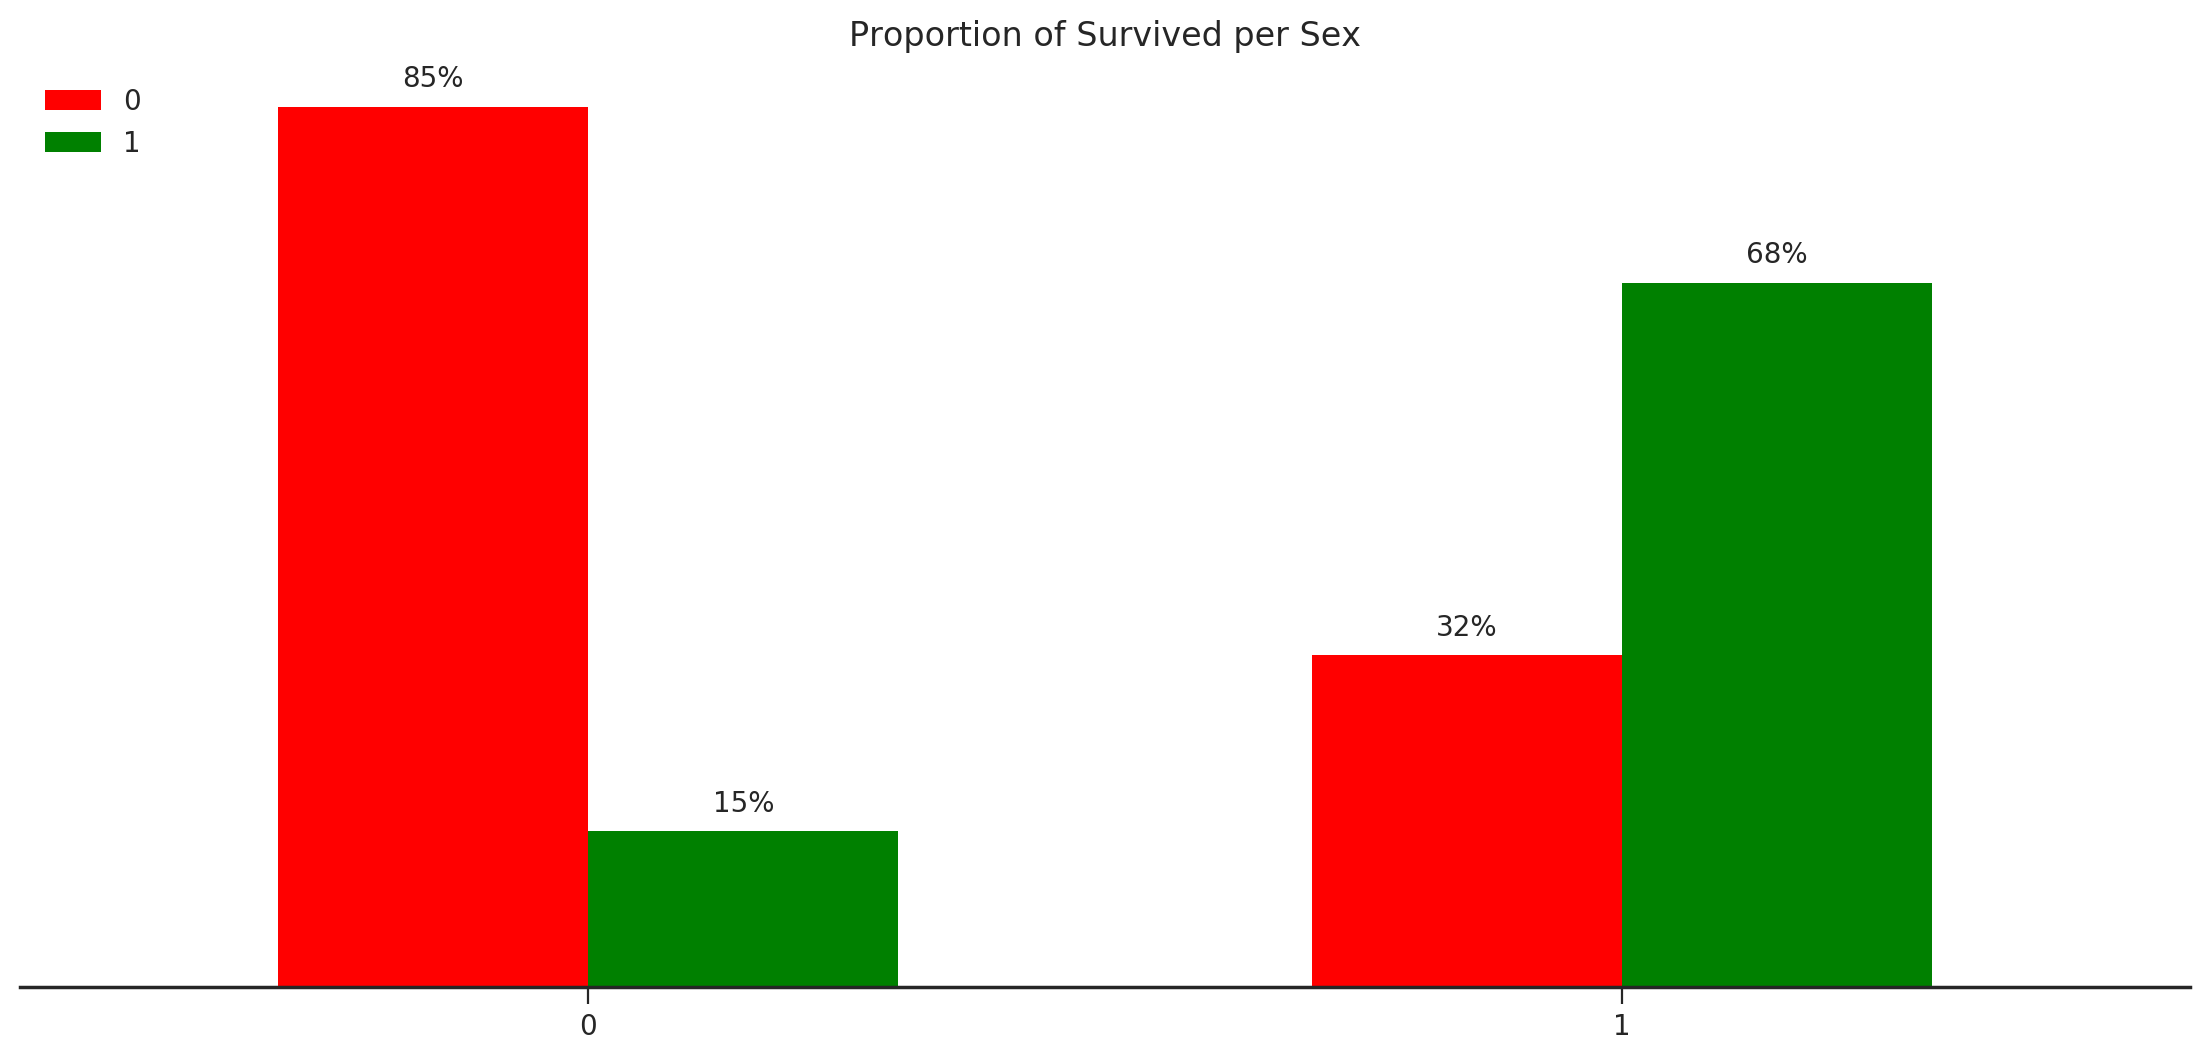

In [16]:
Groupby_TwoCol_Plot(df,
                    'survived',
                    'sex',
                    color_palette=('red','green'),
                    plt_style = 'seaborn-ticks',
                    custom_title='Proportion of Survived per Sex',
                    legloc='upper left')

# Preparar

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
features_target = ['sex', 'age', 'survived']

In [19]:
df = df.filter(features_target)

In [20]:
df.head()

,sex,age,survived
0,0,39.0,0
1,1,26.0,0
2,1,40.0,1
3,0,25.0,0
4,0,-1.0,0


In [21]:
train, test = train_test_split(df, test_size=0.2)

# Modelar

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)

In [24]:
X = train[features_target[:-1]]
Y = train[features_target[-1:]]

In [25]:
X.head()

,sex,age
707,0,-1.0
834,0,-1.0
579,0,35.0
165,0,32.0
380,1,18.0


In [26]:
model.fit(X, Y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Validar

In [27]:
pred = model.predict(test[features_target[:-1]])

In [28]:
acc = np.mean(test[features_target[-1:]].values == pred)
display(acc)

0.529789956618083

# Criar artefatos

https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html

## Upload dos datasets de treino e teste

In [29]:
bucket = 'mlopsstack-mlbucket12760f44-590xj4q47o7h'
prefix = 'datasets/titanic'

In [30]:
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = prefix + '/' + channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

In [31]:
train.to_csv('train.csv')
test.to_csv('test.csv')
upload_to_s3('train', 'train.csv')
upload_to_s3('test', 'test.csv')

## Criação do script de preparação ou usar SageMaker Data Wrangler

- https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/use-scikit-learn-processing-container.html
- https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/data-wrangler-getting-started.html

## Criação do script de treino e inferência

In [32]:
from sagemaker.sklearn.estimator import SKLearn

In [33]:
%%writefile train_inference.py

import argparse
import joblib
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# inference function
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ == "__main__":
    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n-estimators", type=int, default=100)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train.csv")
    parser.add_argument("--test-file", type=str, default="test.csv")
    parser.add_argument("--features", type=str)
    parser.add_argument("--target", type=str) 

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df[args.features.split()]
    X_test = test_df[args.features.split()]
    y_train = train_df[args.target]
    y_test = test_df[args.target]

    # train
    print("training model")
    model = RandomForestClassifier(
        n_estimators=args.n_estimators, random_state=0, n_jobs=-1
    )

    model.fit(X_train, y_train)

    # print acc
    print("validating model")
    pred = model.predict(X_test)
    acc = np.mean(y_test == pred)
    print("Accuracy: " + str(acc))

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)


Overwriting train_inference.py


In [34]:
! python train.py --n-estimators 100 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   --features 'sex age' \
                   --target 'survived'

extracting arguments
reading data
building training and testing datasets
training model
validating model
Accuracy: 0.7653631284916201
model persisted at ./model.joblib


In [35]:
# We use the Estimator from the SageMaker Python SDK
FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="train_inference.py",
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="titanic-scikit",
    metric_definitions=[{"Name": "Accuracy", "Regex": "Accuracy: ([0-9.]+).*$"}],
    hyperparameters={
        "n-estimators": 100,
        "features": "sex age",
        "target": "survived",
    },
)

In [36]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": f"s3://{bucket}/{prefix}/train/", "test": f"s3://{bucket}/{prefix}/test/"}, wait=True)

2022-10-24 13:37:58 Starting - Starting the training job...
2022-10-24 13:38:22 Starting - Preparing the instances for trainingProfilerReport-1666618678: InProgress
.........
2022-10-24 13:39:43 Downloading - Downloading input data...
2022-10-24 13:40:23 Training - Downloading the training image..2022-10-24 13:40:36,651 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-10-24 13:40:36,654 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-24 13:40:36,664 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-10-24 13:40:37,155 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-24 13:40:37,170 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-24 13:40:37,180 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-24 13:40:37,189 sagemaker-training-toolkit INFO     Inv

In [37]:
# Deploy my estimator to a SageMaker Endpoint and get a Predictor
predictor = sklearn_estimator.deploy(instance_type='ml.m4.xlarge',
                                     initial_instance_count=1)

--------!

In [38]:
response = predictor.predict(test[features_target[:-1]])

In [40]:
response

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0])

In [39]:
# predictor.delete_endpoint(delete_endpoint_config=True)

## Criação do script de validação

- https://docs.amazonaws.cn/en_us/sagemaker/latest/dg/use-scikit-learn-processing-container.html